In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Embedding, Conv2D, MaxPooling2D,
                                     Flatten, Concatenate, Dense, Dropout, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df_train = pd.read_csv('/content/df_train_clean.csv')
df_dev = pd.read_csv('/content/df_dev_clean.csv')
df_test = pd.read_csv('/content/df_test_clean.csv')

print(df_train.head())
print(df_dev.head())
print(df_test.head())

   Unnamed: 0    Emotion                                            content  \
0         188      Other              cho mình xin bài nhạc tên là gì với ạ   
1         166    Disgust  cho đáng đời con quỷ . về nhà lôi con nhà mày ...   
2        1345    Disgust  lo học đi . yêu đương lol gì hay lại thích học...   
3         316  Enjoyment    uớc gì sau này về già vẫn có thể như cụ này :))   
4        1225  Enjoyment  mỗi lần có video của con là cứ coi đi coi lại ...   

                                       content_clean  
0              cho mình xin bài nhạc tên là gì với ạ  
1  cho đáng đời con quỷ . về nhà lôi con nhà mày ...  
2  lo học đi . yêu đương lồn gì hay lại thích học...  
3     uớc gì sau này về già vẫn có thể như cụ này ☺️  
4  mỗi lần có video của con là cứ coi đi coi lại ...  
   Unnamed: 0    Emotion                                            content  \
0         941      Other  tính tao tao biết , chẳng có chuyện gì có thể ...   
1         142  Enjoyment           lạ

In [3]:
text_col = 'content_clean'
label_col = 'Emotion'

In [4]:
all_labels = pd.concat([df_train[label_col], df_dev[label_col], df_test[label_col]])
le = LabelEncoder()
le.fit(all_labels)
num_classes = len(le.classes_)

In [5]:
all_text = pd.concat([df_train[text_col], df_dev[text_col], df_test[text_col]])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
vocab_size = len(tokenizer.word_index) + 1
max_seq_len = 100

In [6]:
def encode_text(df):
    return pad_sequences(tokenizer.texts_to_sequences(df[text_col]), maxlen=max_seq_len)

In [7]:
X_train = encode_text(df_train)
X_dev = encode_text(df_dev)
X_test = encode_text(df_test)

y_train = le.transform(df_train[label_col])
y_dev = le.transform(df_dev[label_col])
y_test = le.transform(df_test[label_col])

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_dev_cat = tf.keras.utils.to_categorical(y_dev, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
def build_text_cnn(vocab_size, max_seq_len, num_classes, embed_dim=128, dropout_rate=0.2):
    input_layer = Input(shape=(max_seq_len,))
    embedding = Embedding(vocab_size, embed_dim, input_length=max_seq_len)(input_layer)
    reshape = Reshape((max_seq_len, embed_dim, 1))(embedding)

    filter_sizes = [1, 2, 3, 5]
    convs = []
    for size in filter_sizes:
        conv = Conv2D(
            filters=32,
            kernel_size=(size, embed_dim),
            activation='relu'
        )(reshape)
        pool = MaxPooling2D(pool_size=(max_seq_len - size + 1, 1))(conv)
        convs.append(pool)
    merged = Concatenate(axis=1)(convs)
    flatten = Flatten()(merged)
    dropout = Dropout(dropout_rate)(flatten)
    output = Dense(num_classes, activation='softmax')(dropout)
    model = Model(inputs=input_layer, outputs=output)
    return model

In [9]:
model = build_text_cnn(vocab_size, max_seq_len, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │    597,120 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 100, 128,  │          0 │ embedding[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 1,    │      4,128 │ reshape[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 99, 1, 32) │      8,224 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 98, 1, 32) │     12,320 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 96, 1, 32) │     20,512 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 1, 1, 32)  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 1, 32)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 1, 1, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1, 1, 32)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 1, 32)  │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │                   │            │ max_pooling2d_1[… │
│                     │                   │            │ max_pooling2d_2[… │
│                     │                   │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 7)         │        903 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 643,207 (2.45 MB)

 Trainable params: 643,207 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(X_dev, y_dev_cat)
)

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.2917 - loss: 1.8040 - val_accuracy: 0.4854 - val_loss: 1.4378
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.5520 - loss: 1.2908 - val_accuracy: 0.5496 - val_loss: 1.2312
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.6807 - loss: 0.9448 - val_accuracy: 0.5554 - val_loss: 1.1843
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.7663 - loss: 0.6938 - val_accuracy: 0.5671 - val_loss: 1.2244
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.8327 - loss: 0.5234 - val_accuracy: 0.5554 - val_loss: 1.3237
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8835 - loss: 0.3654 - val_accuracy: 0.5394 - val_loss: 1.4315
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9178 - loss: 0.2779 - val_accuracy: 0.5437 - val_loss: 1.5452
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9537 - loss: 0.1896 - 

In [11]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

       Anger     0.3714    0.3250    0.3467        40
     Disgust     0.5147    0.5303    0.5224       132
   Enjoyment     0.6462    0.6528    0.6495       193
        Fear     0.7105    0.5870    0.6429        46
       Other     0.4118    0.4884    0.4468       129
     Sadness     0.6389    0.5948    0.6161       116
    Surprise     0.6071    0.4595    0.5231        37

    accuracy                         0.5556       693
   macro avg     0.5572    0.5197    0.5353       693
weighted avg     0.5626    0.5556    0.5573       693



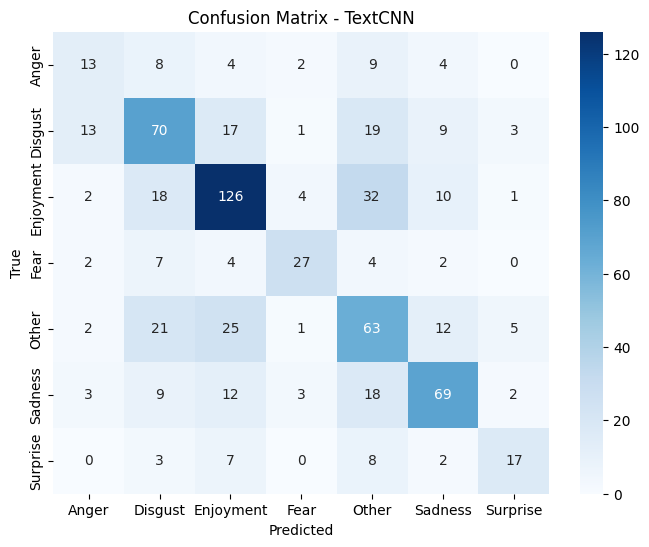

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - TextCNN')
plt.show()

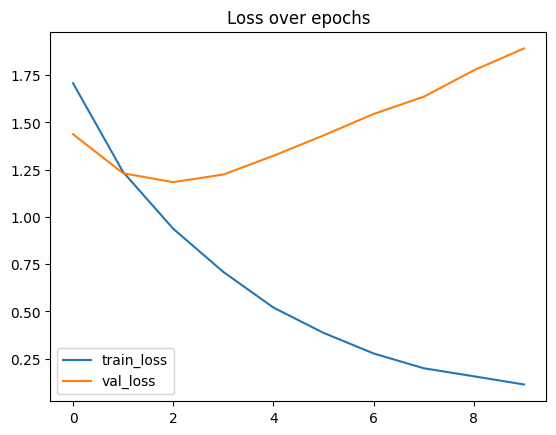

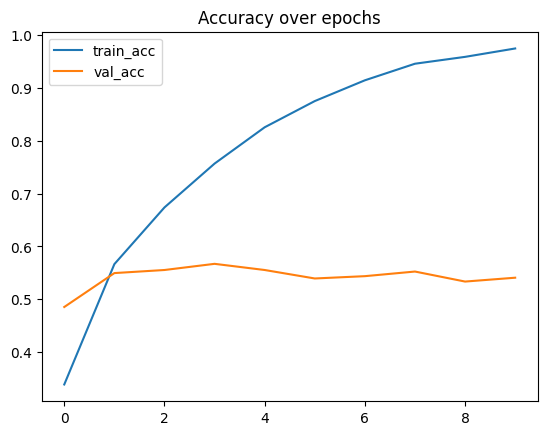

In [13]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss over epochs"); plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Accuracy over epochs"); plt.show()